In [1]:
import handcalcs.render

# 6.1 매개변수 갱신

### 1. 확률적 경사 하강법 (SGD)
$$W := W - \eta \frac{\partial L}{\partial W}$$

In [2]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

### 2. Momentum
$$v := \alpha v - \eta \frac{\partial L}{\partial W}$$
$$W := W + v$$
<br>
$$v: velocity (속도)$$
$$\alpha: momentum (ex. 0.9)$$

In [3]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

### 3. AdaGrad
##### learning rate decay -> Adaptive learning rate fit

$$h := h + \frac{\partial L}{\partial W} \odot \frac{\partial L}{\partial W}$$
$$W := W - \eta \frac{1}{\sqrt h} \frac{\partial L}{\partial W}$$

- h: 각 기울기 원소 값 제곱하여 더한 후 업데이트
- W: 1/sqrt(h) 를 통해 크게 갱신된 원소는 학습률 낮게 업데이트
- 학습 진행할수록 갱신 강도 0으로 수렴 -> 문제 개선: RMSProp (먼 과거의 기울기 잊고 새 기울기 정보 크게 반영)

In [4]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}    
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7) # h=0일 경우 대비

### 4. Adam
Momentum + AdaGrad

In [5]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

# 6.2 가중치 초깃값

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

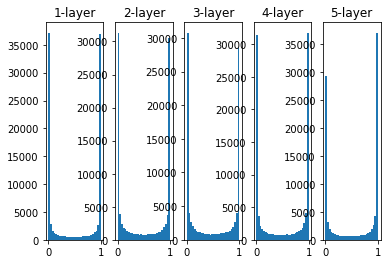

In [13]:
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

- 각 층의 활성화 출력 값: 0, 1에 치우져 있다.
- 기울기 소실 (gradient vanishing) 문제.

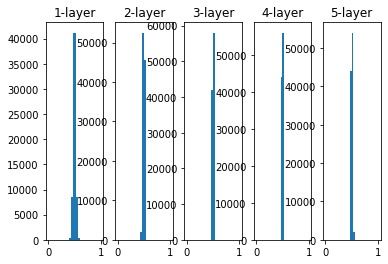

In [15]:
# 표준편차 1 -> 0.01

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

- 기울기 소실 문제는 해결, but 다수의 뉴런이 거의 같은 값
- 활성화 값들이 치우져 "표현력 제한" 문제

### Xavier 초깃값
- 표준편차: $$\frac{1}{\sqrt n}$$
- n: 앞 층의 노드 수

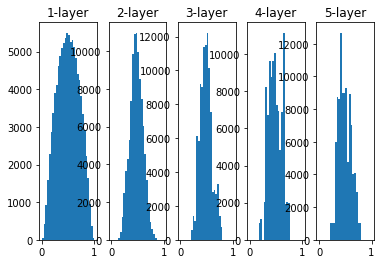

In [17]:
# 표준편차 1/sqrt(n)

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

- Xavier 초깃값은 선형 활성화 함수를 전제한 결과임. (sigmoid, tanh)
- ReLU에 특화된 초깃값은 "He 초깃값" :
$$\sqrt \frac{2}{n}$$
ReLU의 경우 음의 영역이 0이어서 2배 더 넓게 분포시킴

In [49]:
x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

def ReLU(x):
    return np.maximum(0, x)

In [50]:
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = np.random.randn(node_num, node_num) * np.sqrt(2 / node_num)
    
    a = np.dot(x, w)
    z = ReLU(a)
    activations[i] = z

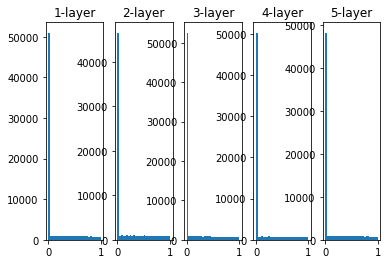

In [51]:
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

# 6.3 Batch Normalization
- 학습 속도 개선
- 초깃값 의존도 감소
- 오버피팅 억제 (드롭아웃 등 필요성 감소)

각 층에서 활성화 값이 적당히 분포되도록 강제하는 것.

... - Affine - Batch Norm - ReLU - Affine - ...


- 데이터 분포의 평균이 0, 분산이 1이 되도록 정규화
$$\mu_B := \frac{1}{m} \sum_{i=1}^m x_i$$
$$\sigma_B^2 := \frac{1}{m} \sum_{i=1}^m (x_i - \mu_B)^2$$
$$\hat x_i := \frac{x_i - \mu_B}{\sqrt \sigma_B^2 + \varepsilon}$$

# 6.4 오버피팅
 오버피팅:
1. 매개변수가 많고 표현력이 높은 모델
2. 훈련 데이터가 적음